In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import ast as ast
from typing import *
from task_2_helpers import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob

# nltk utils 
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('universal_tagset')
# nltk.download('wordnet')


## 2.0 Data Preprocessing

We started our analysis by reading the business, reviews and users datasets. We select the businesses located in Philadelphia. To do so, we used the Postal Code column. According to out research, Philadelphia postal codes fall in the range of [19019, 19255].

In [3]:
### Data Read
df_business = pd.read_csv('data/ATML2024_businesses.csv', header=0)
print(f"Business data: {df_business.shape}, columns: {list(df_business.columns)}")

df_Train_reviews = pd.read_csv('data/ATML2024_reviews_train.csv', header=0)
print(f"Reviews data: {df_Train_reviews.shape}, columns: {list(df_Train_reviews.columns)}")

df_users = pd.read_csv('data/ATML2024_users.csv', header=0)
print(f"Users data: {df_users.shape}, columns: {list(df_users.columns)}")


Business data: (138210, 11), columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'attributes', 'categories', 'hours']
Reviews data: (1050000, 9), columns: ['id', 'user_id', 'business_id', 'rating', 'useful', 'funny', 'cool', 'text', 'date']
Users data: (747468, 19), columns: ['user_id', 'name', 'user_since', 'useful', 'funny', 'cool', 'premium_account', 'friends', 'fans', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer']


Following data cleaning methods applied to the business data columns:
- **postal_code:** converted to numeric and selected the values in [19019, 19255] for Philadelphia
- **attributes:** cast as dictionary; attributes that value:True are extracted and add to the list of attributes. We also extracted the nested attributes in the similar and add them into list in the form of main attirbute-nested attribute.
- **hours:** cast as dictionary; converted to list of list of working hours per day of the week. Each row has a list size 7, representing the work day and each index have a list of size 2 repsenting the working hour of the day ast [start h, end h]. If a business doens't operate a specific day we put [-1,-1] as working hour.
- **categories:** converted from comma seperated string to list of categories  

After cleaning and selection, we merge business data with ratings data. We only keep the columns that are of our interest for the future usage. Since we are only interested in the restaurant businesses in Philadelphia, we further trim our dataset to contain only the restaurant businesses. We do that by selecting rows those category list includes restaurants. After our many observations we concluded that such a selection criteria is enough to identify the vast majority of restaurant businesses in Philadelphia.

In [4]:
df_business_ph = select_preprocess_Phili_business(df_business)
print("Philadelphia businesses data", df_business_ph.shape)

df_data = pd.merge(df_business_ph[['business_id', 'postal_code_int', 'attributes_list', 'hours_list', 'categories_list', 'latitude', 'longitude']],
                   df_Train_reviews, left_on= 'business_id', right_on='business_id')

print("Philadelphia businesses with ratings data", df_data.shape)


# Select only restaurant businesses
df_data_res = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x)
                       or any('restaurant' in str(a).lower() for a in x))]

print("Philadelphia restaurant businesses with ratings data", df_data_res.shape)

df_data_res.to_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet')
df_data_res.head(5)

Philadelphia businesses data (19707, 15)
Philadelphia businesses with ratings data (176549, 15)
Philadelphia restaurant businesses with ratings data (123414, 15)


,business_id,postal_code_int,attributes_list,hours_list,categories_list,latitude,longitude,id,user_id,rating,useful,funny,cool,text,date
0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,100621,Ax5a6F5AaOoPi-1MwOeuaM,4,1,0,2,So I don't know how the other review was doubl...,2017-08-24 04:23:03
1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,174063,QZ7nC0AgxLr9B5E0IYguyf,5,0,0,0,I love this place.. I love their chunky fried...,2020-05-25 16:27:36
2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,234948,gnTp6PHiW40FPYsSwXt37u,5,0,0,1,I ordered so many cake from here for our famil...,2019-07-25 13:09:14
3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,285755,wKRfxlkzQXfEsHSDYhPVVq,4,0,0,0,Ordered a birthday cake here for the first tim...,2019-03-12 17:04:09
4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",39.955505,-75.155564,330446,QikAd9bkgEVafOR5e5EeqW,5,1,0,0,This is my favorite bakery in Chinatown! It's ...,2017-09-13 00:38:08


## Data Read

In [3]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)
# df_data_res.head(5)

(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


## 2.1 Aspect Based Sentiment Analysis

In this section we perform a so-called Aspect-Based Sentiment Analysis.
The idea is to give a sentiment to a review based on a list of predifined aspect. For example in the sentence : 

<br> "The food was great in a clean place. However the service was terrible." <br>

We would like to extract a positive sentiment for food and a negative sentiment for service.
Aspects are manually selected. We choose to expose the results using the aspects : "food" and "service".

Extensive list of words related to another word or theme can be find in NLP libraires such as nltk. For the sake of simplicity we use a predefined list.<br>
We also lemmatize all the reviews. This is done in the `lemmatize_string` from our util functions. It is based on nltk librairy. 


In [4]:
# Predefined aspects and their related keywords
aspects_keywords = {
    "food": ["food", "dish", "meal", "taste", "flavor"],
    "service": ["service", "staff", "waiter", "waitress"],
    "price":["cost","fee","rate","price","fare","value","expense","cheap","expensive"]
}
# Lemmatize 
for key, item in aspects_keywords.items():
    aspects_keywords[key] = [lemmatize_string(it) for it in item]

In [5]:
# We also lematize all the reviews This might run for a while 
# df_data_res['text_lem'] = df_data_res['text'].apply(lemmatize_string)

First we split the review in n reviews (n being the number of aspects. For example food and service). Notice some parts of the reviews can overlap. It is not a problem. <br>
This is done with the util function `extract_aspect_sentences(review, aspects_keywords)`. It first divides the review in sentences. This is simalar to tokenization, but where the tokens are sentences. The word of the sentence are lemnatized. Finally, for each of those sentences, if one of the aspect keyword appears, the sentence is extracted and appended to a sub-review of that aspect. This is done for all the aspects giving us a dictionary of aspect :: sub-review.

In [6]:
# Example of use 
review = "The food was great in a clean place. However the service was terrible."
aspect_sentences = extract_aspect_sentences(review, aspects_keywords)
print(aspect_sentences)

{'food': ['The food was great in a clean place.'], 'service': ['However the service was terrible.'], 'price': []}


We use a pretrained model blob from TextBlob librairy (similar to nltk) to pereform sentiment analysis. This is done on each of the sub-reviews linked to an aspect. <br> `analyze_aspect` combines aspect extraction as above and sentiment classification per aspect. The sentiment analysis per aspect is done with pretrained `blob` model from `TextBlob` librairy. Better sentiment analysis could be obtained using transformers at the cost of expensive computational power requirement. 

In [7]:
# Example of use 
reviews = ["The food was great in a clean place. However the service was terrible.",
           "Nice food. Clean place. Good price."]
aspect_sentiments = [analyze_aspects(review, aspects_keywords) for review in reviews]
for it, r in enumerate(reviews):
    print('\'{}\' \n {}'.format(r, aspect_sentiments[it]))
    print('')

'The food was great in a clean place. However the service was terrible.' 
 {'food': 'positive', 'service': 'negative', 'price': 'neutral'}

'Nice food. Clean place. Good price.' 
 {'food': 'positive', 'service': 'neutral', 'price': 'positive'}



The piece of code below is performing the aspect-based sentiment analysis on each all the reviews and and create a column for each of the aspect the sentiment analysis applies. 

In [8]:
score = {}
for key in aspects_keywords:
    score[key] = []

# Iterate all reviews in ['text'] column of the DataFrame
for index, row in df_data_res.iterrows():
    aspect_score = analyze_aspects(row['text'], aspects_keywords)
    for key in aspects_keywords:
        score[key].append(aspect_score[key])

# Append to the right of the dataframe
df_aspect_score = pd.DataFrame(score)
if not bool([ii for ii in list(aspects_keywords.keys()) if ii in df_data_res.columns]):
    df_data_res = pd.merge(df_data_res, df_aspect_score, left_index=True, right_index=True)

Below the ratio of positive to negative sentiment and positive to all sentiments is computed.

In [9]:
sentiment_count = {}
sentiment_ratio  = {}
sentiment_ratio_all = {}
for key in score:
    sentiment_count[key] = Counter(score[key])
    sentiment_count[key] = dict(sorted(sentiment_count[key].items()))
    sentiment_ratio[key] = sentiment_count[key]['positive'] / ( sentiment_count[key]['positive'] + \
                                                               sentiment_count[key]['negative'])
    sentiment_ratio_all[key] = sentiment_count[key]['positive'] / \
                             ( sentiment_count[key]['positive'] + sentiment_count[key]['negative'] + \
                               sentiment_count[key]['neutral'] )

print('Sentiment Ratio = {}'.format(sentiment_ratio))

Sentiment Ratio = {'food': 0.8062085593731163, 'service': 0.8189185237786921, 'price': 0.7645313410692524}


The aspect `price` gets a lower score. <br>
Plot the sentiment count 

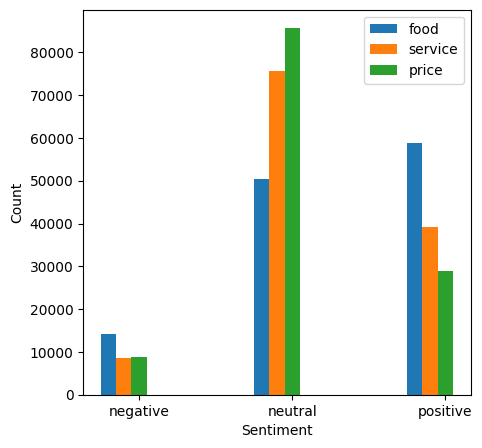

In [10]:
plt.figure(figsize=(5,5))
shift = 0
for key in score:
    names  = list(sentiment_count[key].keys())
    values = list(sentiment_count[key].values())
    plt.bar(np.arange(len(sentiment_count[key]))+shift, values, tick_label=names, width=0.1, label=key)
    shift += 0.1
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.legend(loc='best')
plt.show()

More than half of the reviews are without sentiment. We identify the following possible reasons : 
- The review is not refering to the aspect. It is possible that the people talk less frequently of the price than the food or service. 
- The way aspects are extracted is basic. It is explicitely looking if lemmatized word qualifying some aspect appears in the lemmatized review. It could be that the review talks about an aspect without using any of the predifined words.

One can also look at the ratio of positive to negatif sentiments 

To summerize this part, one can see that in general the reviews with extracted aspects are positive. Reviewers seem to be more critic towards the price than the food or the service. 

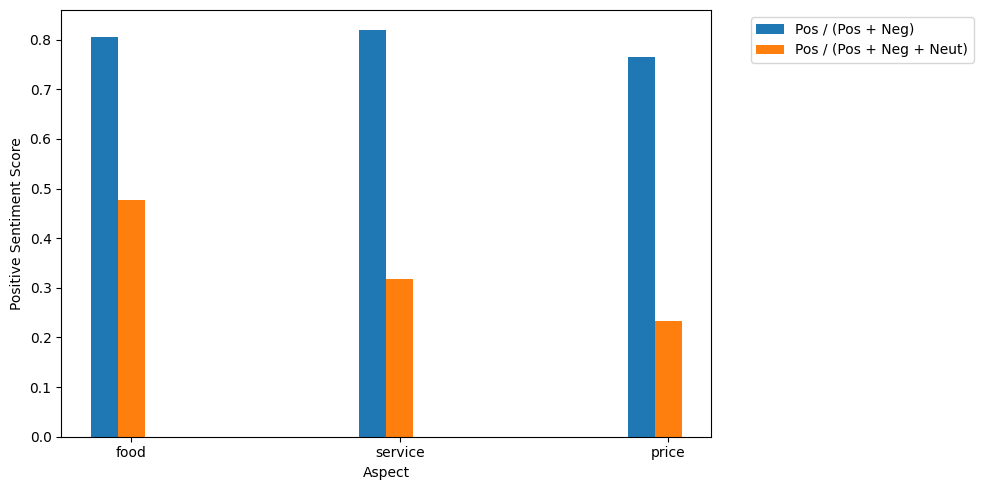

In [11]:
plt.figure(figsize=(10,5))

aspect = list(sentiment_ratio.keys())

plt.bar(np.arange(len(aspect)), list(sentiment_ratio.values()), tick_label=aspect, width=0.1, label='Pos / (Pos + Neg)')
plt.bar(np.arange(len(aspect))+0.1, list(sentiment_ratio_all.values()), tick_label=aspect, width=0.1, label='Pos / (Pos + Neg + Neut)')
plt.xlabel('Aspect')
plt.ylabel('Positive Sentiment Score')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

## 2.2 Food Trends Over Time

We can analyse the food trends by two steps:

1 -  We have the category information of the restaurants and their rating. We can distribute these ratings among the categories and take an average per category. This approach gives us a generic liking of the certain categories. However, it doesn't show the trend. We also count the number of time a category appeared in the dataset. This shows the interest of the people to the certain style of restaurants. Using the average rating and the frequency we identify the most trendy restaurant categories. 

2 - Some categories such as `food`, `restaurant` are quite common where as some categories are rather rare such as `american (traditional)` or `burger`. To identify the importance we calculate **rating-frequency ratio** (`rating_freq_ratio`) which gives number percentage of the restaurants-rating a category exists. We apply 5% filter on this value to discard the categories that are rare in the restaurant business.

3 - From there we can identify the food trends. Most of the categories are related with the food style. We select the most trending 10 food style. We then calculate their corresponding rating by time and draw the evolution of the ratings by time


In [12]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)
# df_data_res.head(5)


(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


In [13]:
data_cat_ratings =  df_data_res[['id','date','categories_list', 'rating']]
data_cat_rating_single = data_cat_ratings.explode('categories_list')
data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rating_freq_ratio'] = data_cat_rating_single['frequency']/len(data_cat_ratings)
data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}) #.set_index('date')

data_cat = data_cat[(data_cat['rating_freq_ratio'] > 0.05) ]
# data_cat.hist()

data_cat.sort_values(by='mean_rating', ascending=False, inplace=True)
data_cat.head(20)


,categories,frequency,mean_rating,rating_freq_ratio
176519,specialty food,7207,4.072430,0.058397
176363,cafes,7019,4.055706,0.056874
176005,vegetarian,6366,4.024505,0.051582
176160,desserts,6404,4.011555,0.051890
175591,beer,6226,4.008834,0.050448
175591,wine & spirits,6226,4.008834,0.050448
176522,coffee & tea,11148,3.974435,0.090330
175692,japanese,6805,3.907127,0.055140
176522,food,37842,3.888642,0.306626
174802,asian fusion,6733,3.877469,0.054556


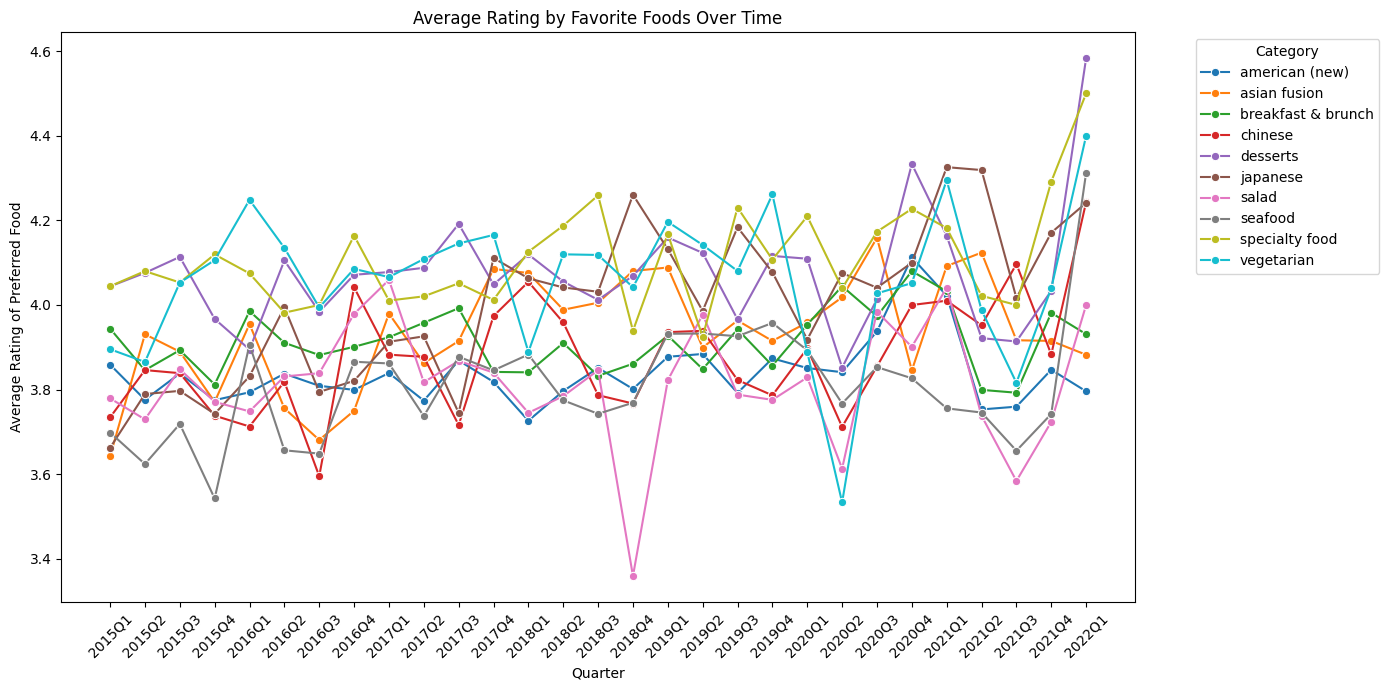

In [14]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])
data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)
df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).rating.mean().reset_index()

df_pivot = df_grouped.pivot(index='quarter', columns='categories', values='rating')
df_pivot = df_pivot.sort_index()

plot_trending_figures(df_grouped,  x='quarter', y='rating', hue='categories', marker='o',
                    legend='Category', xlabel='Quarter', ylabel='Average Rating of Preferred Food',
                    title='Average Rating by Favorite Foods Over Time')


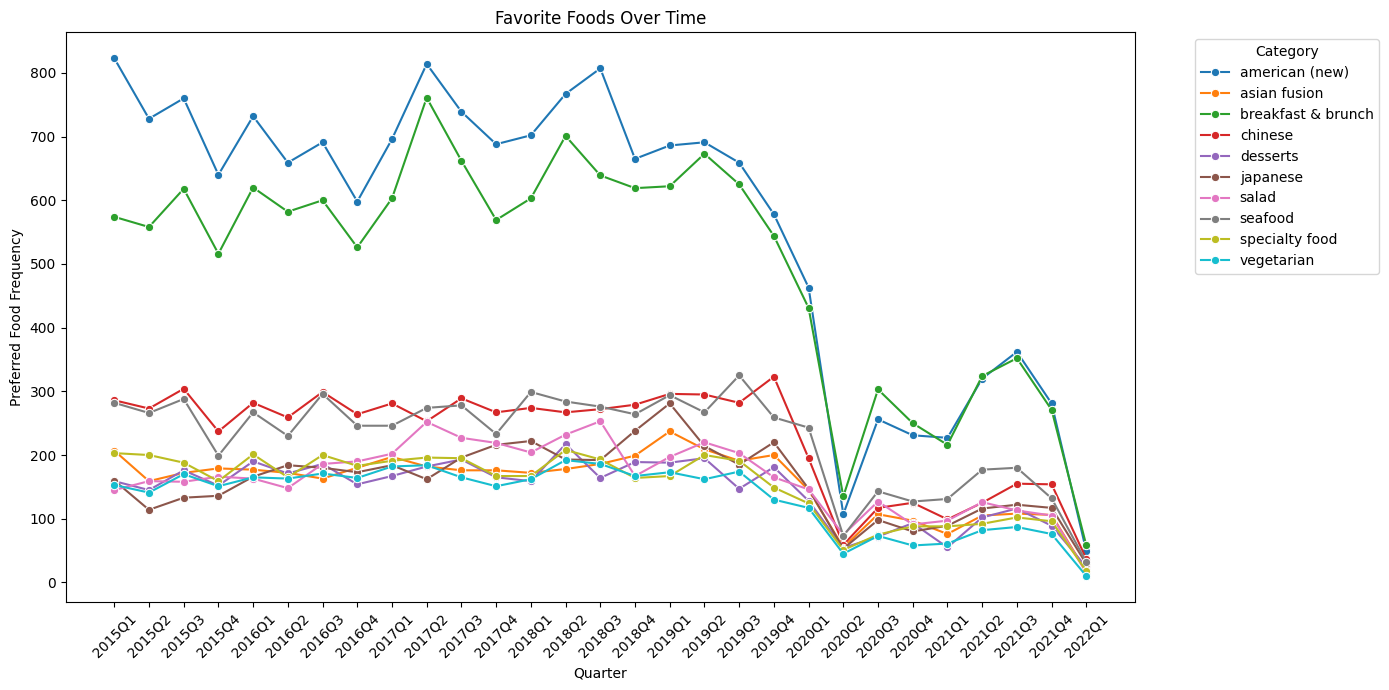

In [15]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])
data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)
df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).size().reset_index(name='frequency')



plot_trending_figures(df_grouped,  x='quarter', y='frequency', hue='categories', marker='o',
                    legend='Category', xlabel='Quarter', ylabel='Preferred Food Frequency', 
                    title='Favorite Foods Over Time')


## 2.3 Suggestions for the restaurants

We can apply the similar method to the attributes of the restaurants. We can find the most appreciated attributes and see their combined effect on the rating. We also cut the attributes that present less than 5% of the restaurants. They're indeed very rare ones. Although such attributes yield high average ratings they may not reflect the values reality accurately.

Unlike categories attribues seem to distribute more uniformly. Average rating per attribute is found 3.8 and average presence of the atributes are found 50%. Many attributes are very common such as `RestaurantsTakeOut` or `RestaurantsDelivery` which exist 98% of the restaurants in our dataset. Similar to categories, some attributes are rare. We apply the same `rating_freq_ratio` 5% limit to the attributes.

To focus on rarer yet valuable attributes we develop a strategy to assign weights to importance of the presence of an attribute, its ratio and and its mean rating. We selected the attributes which present less than 90% and more than 10% of the restaurants. In addition, we selected the attributes which have more than 3.75 average rating. We concluded these values visually by looking at their respective distribution. Finally, we assigned 0.5 weight on the mean rating and 0.25 weight on frequency and rating_frequency ratio, normalize the values with MinMax scale and calculated a composite score. The importance of the attributes could be seen in the heat map below.


In [16]:
data_att_ratings =  df_data_res[['id','date','attributes_list', 'rating']] 
data_att_rating_single = data_att_ratings.explode('attributes_list')
data_att_rating_single['mean_rating'] = data_att_rating_single[['attributes_list', 'rating']]\
                        .groupby('attributes_list')['rating'].transform('mean')

data_att_rating_single['frequency'] = data_att_rating_single['attributes_list'].map(data_att_rating_single['attributes_list'].value_counts())
data_att_rating_single['rating_freq_ratio'] = data_att_rating_single['frequency']/len(data_att_ratings)
data_att = data_att_rating_single[['attributes_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes'}) #.set_index('date')

data_att = data_att[(data_att['rating_freq_ratio'] > 0.05) ]
data_att.sort_values(by='mean_rating', ascending=False, inplace=True)
data_att.head(5)
# data_att_generic = data_att[data_att.mean_rating > 3.8].sort_values(by='rating_freq_ratio', ascending=False)
# data_att_generic = data_att[(data_att.mean_rating > 3.8) & (data_att.rating_freq_ratio < 0.9)].sort_values(by='rating_freq_ratio', ascending=False)

,attributes,frequency,mean_rating,rating_freq_ratio
175989,ByAppointmentOnly,20975.0,4.029273,0.169956
176422,BYOB,18047.0,3.962653,0.146231
176363,GoodForMeal-brunch,14885.0,3.953846,0.120610
176420,DogsAllowed,58831.0,3.952797,0.476696
176420,Ambience-trendy,17443.0,3.941352,0.141337


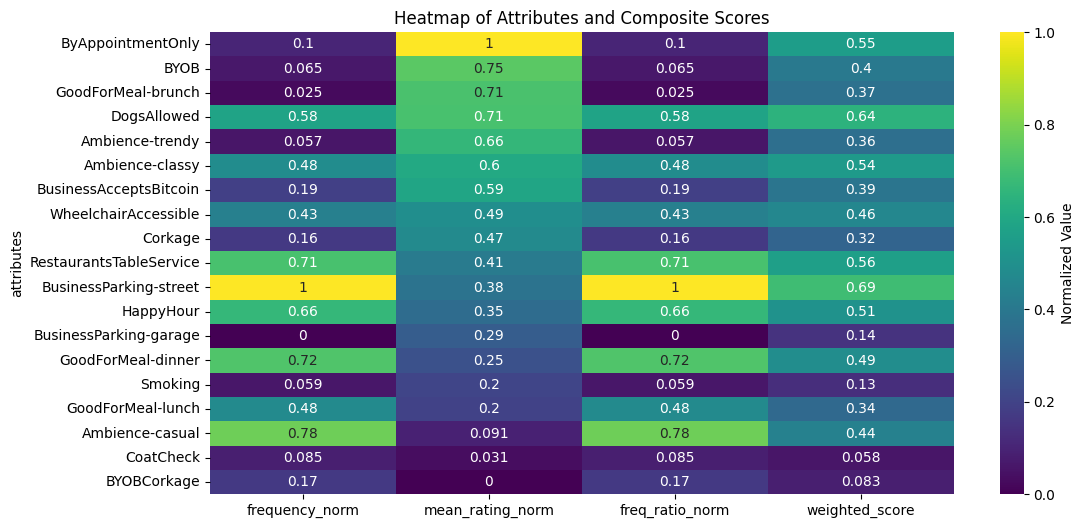

In [17]:
df = data_att[(data_att.mean_rating >= 3.75) & (data_att.rating_freq_ratio < 0.9) & (data_att.rating_freq_ratio > 0.10)].sort_values(by='mean_rating', ascending=False)

# Normalize the metrics
scaler = MinMaxScaler()
df[['frequency_norm', 'mean_rating_norm', 'freq_ratio_norm']] = scaler.fit_transform(df[['frequency', 'mean_rating', 'rating_freq_ratio']])

# Calculate a weighted score (example weights: frequency=0.3, mean_rating=0.5, freq_ratio=0.2)
weights = {'frequency': 0.25, 'mean_rating': 0.5, 'rating_freq_ratio': 0.25}
df['weighted_score'] = (weights['frequency'] * df['frequency_norm'] +
                        weights['mean_rating'] * df['mean_rating_norm'] +
                        weights['rating_freq_ratio'] * df['freq_ratio_norm'])

# Prepare data for heatmap
heatmap_data = df[['attributes', 'frequency_norm', 'mean_rating_norm', 'freq_ratio_norm', 'weighted_score']].set_index('attributes')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'Normalized Value'})
plt.title('Heatmap of Attributes and Composite Scores')
plt.show()


Along with the generic attributes like `BikeParking`, `CreditCardAcceptance` etc, we recommend a new restaurant to be chic ad elite category. According to our findings, restaurants having following attributes have higher rating potential.
- By Appointment Only
- Business Parking (street is enough)
- Classy and Casual Ambiance
- Table Service
- Dinner meal specialized 
- Happy hour
- Dog friendly



#### Alexis' Heatmap

Generally speaking, we can interpret negativity as frustration and unfulfilled needs. As a result, there"s a chance to be successful in the restaurant business by satisfying unfulfilled needs, and consequently to do good business. To maximize chances of success, one need to target what most consumers are saying by voting. 
Here are our pieces of advice:
1) Their focus should not be on what is appreciated, but on avoiding replicating what is not. That seems be more important.
We see from our findings that consumers appreciate all restaurants in general, with the exception of those that are cheap (in terms of quality) or that don't stand out from the crowd (traditional American cuisine). The focus should therefore be on avoiding those items at the bottom of the rankings. An overall comparison of the heat maps shows that low scores are given to foods that tend to be cheap. These tend to be traditional American cuisine, fast food, pizza and buffets for example.
2) To be successful, they need to assess their risk profile and play strategically with zip codes and set up shop where there's high demand and little supply. This requires additional analysis and domain knowledge.